In [31]:
try:
    import json
    import os
    
    import pandas as  pd
    import numpy as np
    import spacy
    
    import seaborn as sns
    import string

    from tqdm import tqdm
    from textblob import TextBlob
    
    from nltk.corpus import stopwords
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize
    import re
    
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    
    
    from sklearn.preprocessing import FunctionTransformer
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import FeatureUnion
    from sklearn.feature_extraction import DictVectorizer
    
    import swifter
    
    tqdm.pandas()
except Exception as e:
    print("Error : {} ".format(e))

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\subham
[nltk_data]     chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\subham
[nltk_data]     chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\subham
[nltk_data]     chakraborty\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\subham
[nltk_data]     chakraborty\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

<AxesSubplot:>

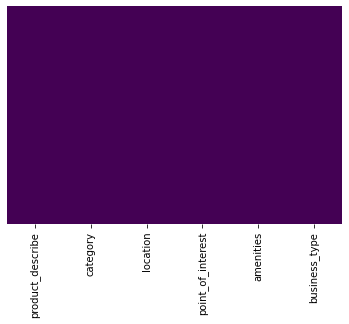

In [12]:
df = pd.read_json("demo_dataset.json", lines=True)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:>

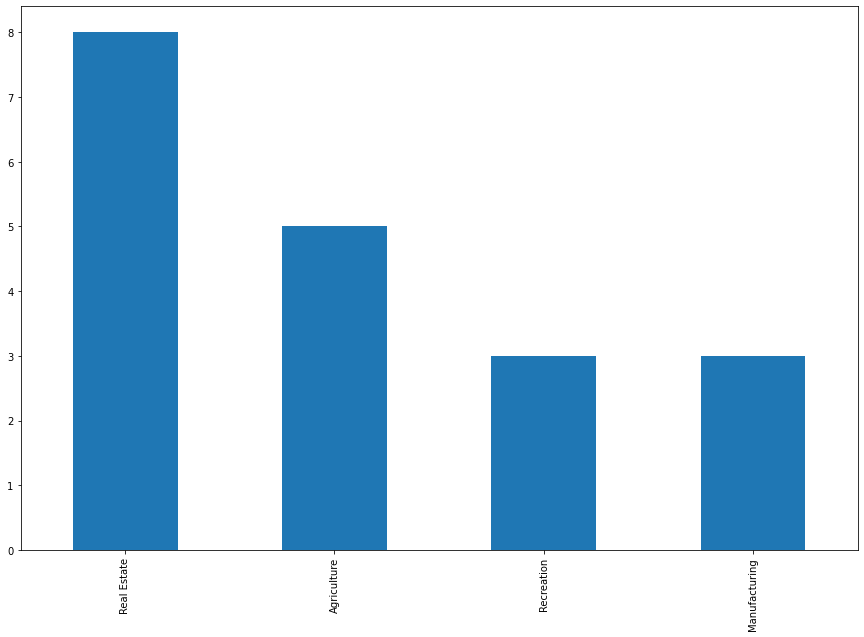

In [14]:
df['business_type'].value_counts().plot( kind='bar', figsize=(15,10))


In [15]:
df.columns

Index(['product_describe', 'category', 'location', 'point_of_interest',
       'amenities', 'business_type'],
      dtype='object')

In [16]:
df.describe()

,product_describe,category,location,point_of_interest,amenities,business_type
count,19,19,19,19,19,19
unique,19,2,18,19,19,4
top,10-acre farmland with river access and mountai...,Land,"Austin, TX",Rocky Mountain National Park,"River Access, Mountain Views, Irrigation Syste...",Real Estate
freq,1,18,2,1,1,8


In [17]:
df.isna().sum()

product_describe     0
category             0
location             0
point_of_interest    0
amenities            0
business_type        0
dtype: int64

In [18]:
df.head(2)

,product_describe,category,location,point_of_interest,amenities,business_type
0,10-acre farmland with river access and mountai...,Land,"Colorado, USA",Rocky Mountain National Park,"River Access, Mountain Views, Irrigation Syste...",Agriculture
1,Prime commercial land in downtown business dis...,Land,"Chicago, IL",Magnificent Mile,"High Visibility, Easy Access to Public Transpo...",Real Estate


In [20]:
df.business_type.unique()

array(['Agriculture', 'Real Estate', 'Recreation', 'Manufacturing'],
      dtype=object)

In [21]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [22]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

def polarity_txt(text):
    return TextBlob(text).sentiment[0]

def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [27]:
df['text'] = df['product_describe']  +  " " + df['point_of_interest']

df['text'] = df['text'].swifter.apply(clean_txt)
df['polarity'] = df['text'].swifter.apply(polarity_txt)
df['subjectivity'] = df['text'].swifter.apply(subj_txt)
df['len'] = df['text'].swifter.apply(lambda x: len(x))
# print(df['text'])

#not needed now

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

In [28]:
X = df[['text', 'polarity', 'subjectivity','len']]
y =df['business_type']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
v = dict(zip(list(y), df['business_type'].to_list()))

In [ ]:
print("Trying the model")

In [29]:
text_clf = Pipeline([
...     ('vect', CountVectorizer(analyzer="word", stop_words="english")),
...     ('tfidf', TfidfTransformer(use_idf=True)),
...     ('clf', MultinomialNB(alpha=.01)),
... ])

In [30]:
text_clf.fit(x_train['text'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [32]:
X_TEST = x_test['text'].to_list()
Y_TEST = list(y_test)

In [33]:
predicted = text_clf.predict(X_TEST)

In [34]:
c = 0

for doc, category in zip(X_TEST, predicted):
    
    if c == 2:break
    
    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
acre farmland pond graze pasture mammoth cave national park
Agriculture
-------------------------------------------------------
-------------------------------------------------------
acre waterfront lot private beach acadia national park
Agriculture
-------------------------------------------------------


In [35]:
np.mean(predicted == Y_TEST)

0.75

In [52]:
docs_new = ['i want a farm land and a beach']
predicted = text_clf.predict(docs_new)
v[predicted[0]]

'Real Estate'

In [51]:
########Saving the model

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(text_clf,f)